In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

#### Model building on reviews that are labeled a 1 or 5 in order to develop model that can classify a positive review, or negative review based on text
- my sample has 50,000 reviews for 1 and 5 stars
- will create wordclouds for each set of 1 and 5 stars before and after removing stop words to explore the data

In [3]:
os.chdir('C:\\YELP\\Round12')
reviews = pd.read_csv('reviews1_5.csv')

In [4]:
#wordclouds
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [5]:
import matplotlib.pyplot as plt
% matplotlib inline

In [6]:
#wordcloud for 5 star ratings
text_5 = " ".join(review for review in reviews['text'].loc[reviews['stars']==5])
print('There are {} words in the combination of all 5 star reviews in sample.'.format(len(text_5)))

There are 24128489 words in the combination of all 5 star reviews in sample.


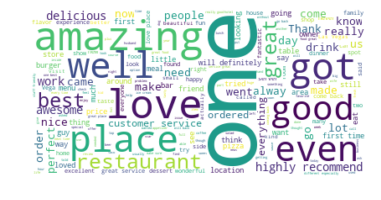

In [7]:
# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text_5)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [8]:
#wordcloud for 1 star ratings
text_1 = " ".join(review for review in reviews['text'].loc[reviews['stars']==1])
print('There are {} words in the combination of all 1 star reviews in sample.'.format(len(text_1)))

There are 37945574 words in the combination of all 1 star reviews in sample.


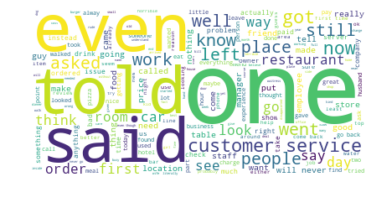

In [9]:
# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text_1)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Generate wordclouds for 1 and 5 star ratings after removing english and user defined stopwords based on words that I observe above in both wordclouds

In [10]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [11]:
import string

In [12]:
#remove stop words and punctation, plus user defined stop words
user_defined_stop_words = ['one','got','restaurant','place','even','went']
i = stopwords.words('english')
j = list(string.punctuation) + user_defined_stop_words
stopwords = set(i).union(j)

In [13]:
import re

In [14]:
def preprocess(x):
    x = re.sub('[^a-z\s]', '', x.lower())                  # get rid of noise
    x = [w for w in x.split() if w not in set(stopwords)]  # remove stopwords
    return ' '.join(x)     

In [15]:
reviews['text_clean'] = reviews['text'].apply(preprocess)

In [16]:
#filter df to only 5 star reviews
text_5 = ' '.join(reviews['text_clean'].loc[reviews['stars']==5])

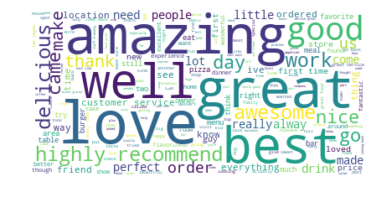

In [17]:
# Generate a word cloud image for 5 star ratings
wordcloud = WordCloud(background_color="white").generate(text_5)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [18]:
#filter df to only 1 star reviews and wordcloud
text_1 = ' '.join(reviews['text_clean'].loc[reviews['stars']==1])

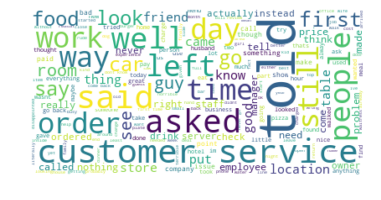

In [19]:
wordcloud = WordCloud(background_color="white").generate(text_1)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Next Steps:
- count vectorize data (tfidf doesn't make a lot of sense in this context as we don't want to penalize terms for being in all reviews)
- split data into train, test, eval sets
- build supervised classifier(NB,SGD), hypertune, and measure results
- perform SVD in order to reduce dimensions and try previous model
- evaluate all models on eval set

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

In [21]:
#generate train, test, and val sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reviews['text_clean'], reviews['stars'], test_size=0.2, random_state=33)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=33)

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [22]:
#build NB classifier
NB = Pipeline([('vect', CountVectorizer()),
                ('clf', MultinomialNB())])

In [23]:
NB = NB.fit(X_train, y_train)
predictions = NB.predict(X_test)

In [24]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          1       0.93      0.94      0.93     10177
          5       0.93      0.93      0.93      9823

avg / total       0.93      0.93      0.93     20000



In [25]:
#build SGD classifier
from sklearn.linear_model import SGDClassifier, ElasticNet

In [26]:
SGD = Pipeline([('vect', CountVectorizer()),
                      ('clf-svm', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42))])

SGD = SGD.fit(X_train, y_train)
predictions_SGD = SGD.predict(X_test)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [27]:
#classification report
print(classification_report(y_test, predictions_SGD))

             precision    recall  f1-score   support

          1       0.96      0.96      0.96     10177
          5       0.96      0.96      0.96      9823

avg / total       0.96      0.96      0.96     20000



In [28]:
#hypertune models
from sklearn.model_selection import GridSearchCV
#NB:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': (1.0, .1, .01)}

In [29]:
gs_clf = GridSearchCV(NB, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)
print(gs_clf.best_score_)
print(gs_clf.best_params_)

0.948578125
{'clf__alpha': 0.1, 'vect__ngram_range': (1, 2)}


In [30]:
#SGD
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
            'clf-svm__alpha': (1e-2, 1e-3),
             'clf-svm__penalty': ('l1', 'l2', 'elasticnet')}

In [31]:
gs_clf_sgd = GridSearchCV(SGD, parameters_svm, n_jobs=-1)
gs_clf_sgd = gs_clf_sgd.fit(X_train, y_train)
print(gs_clf_sgd.best_score_)
print(gs_clf_sgd.best_params_)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.9635625
{'clf-svm__alpha': 0.001, 'clf-svm__penalty': 'l2', 'vect__ngram_range': (1, 2)}


Will now predict test data with hypertuned models

In [32]:
predictions_gs = gs_clf.predict(X_test)
predictions_gs_sgd = gs_clf_sgd.predict(X_test)

In [33]:
print('Hypertuned NB Results on Test Data: \n\n',classification_report(y_test, predictions_gs))
print('Hypertuned SGD Results on Test Data: \n\n',classification_report(y_test, predictions_gs_sgd))

Hypertuned NB Results on Test Data: 

              precision    recall  f1-score   support

          1       0.95      0.96      0.95     10177
          5       0.96      0.94      0.95      9823

avg / total       0.95      0.95      0.95     20000

Hypertuned SGD Results on Test Data: 

              precision    recall  f1-score   support

          1       0.97      0.97      0.97     10177
          5       0.97      0.97      0.97      9823

avg / total       0.97      0.97      0.97     20000



In [34]:
#perform SVD analysis (have to use SVD module because you can't PCA a sparse matrix)
from sklearn.decomposition import TruncatedSVD

In [37]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)
X_val_cv = cv.transform(X_val)

In [38]:
svd = TruncatedSVD(n_components=1000, random_state=33)

svd = svd.fit(X_train_cv)

In [39]:
print(sum(svd.explained_variance_ratio_)) #explained variance is ~72% (tried to make matrix bigger but it crashed my machine)

0.7160295858734184


In [41]:
#transform data
X_train_svd = svd.transform(X_train_cv)
X_test_svd = svd.transform(X_test_cv)

In [42]:
X_val_svd = svd.transform(X_val_cv)

In [43]:
#predict with reduced dimension data
SGD_SVD = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42).fit(X_train_svd, y_train)
predictions_SGD_SVD = SGD_SVD.predict(X_test_svd)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [44]:
print(classification_report(y_test, predictions_SGD_SVD))

             precision    recall  f1-score   support

          1       0.96      0.95      0.96     10177
          5       0.95      0.96      0.95      9823

avg / total       0.96      0.96      0.96     20000



In [45]:
#evaluate all models on val set
val_pred_NB = NB.predict(X_val)
val_pred_NB_gs = gs_clf.predict(X_val)
val_pred_SGD = SGD.predict(X_val)
val_pred_SGD_gs = gs_clf_sgd.predict(X_val)
val_pred_SGD_SVD = SGD_SVD.predict(X_val_svd)

In [46]:
print('Evaluation set results for NB:\n\n',classification_report(y_val, val_pred_NB))
print('Evaluation set results for NB Hypertuned:\n\n',classification_report(y_val, val_pred_NB_gs))
print('Evaluation set results for SGD:\n\n',classification_report(y_val, val_pred_SGD))
print('Evaluation set results for SGD Hypertuned:\n\n',classification_report(y_val, val_pred_SGD_gs))
print('Evaluation set results for SGD SVD:\n\n',classification_report(y_val, val_pred_SGD_SVD))

Evaluation set results for NB:

              precision    recall  f1-score   support

          1       0.93      0.94      0.93      7936
          5       0.94      0.93      0.93      8064

avg / total       0.93      0.93      0.93     16000

Evaluation set results for NB Hypertuned:

              precision    recall  f1-score   support

          1       0.94      0.96      0.95      7936
          5       0.96      0.94      0.95      8064

avg / total       0.95      0.95      0.95     16000

Evaluation set results for SGD:

              precision    recall  f1-score   support

          1       0.97      0.96      0.96      7936
          5       0.96      0.97      0.96      8064

avg / total       0.96      0.96      0.96     16000

Evaluation set results for SGD Hypertuned:

              precision    recall  f1-score   support

          1       0.97      0.97      0.97      7936
          5       0.97      0.97      0.97      8064

avg / total       0.97      0.97      

Unit testing below to see if we can reveal some bias in the model:

In [47]:
def ReviewSentiment(review):
    clean = preprocess(review)
    clean = [clean]
    a = gs_clf_sgd.predict(clean)
    if a[0] == 5:
        print('Positive')
        return True
    else:
        print('Negative')
        return False

In [48]:
ReviewSentiment('This place sucks')

Negative


False

In [49]:
ReviewSentiment('This place had really great service.')

Positive


True

In [50]:
ReviewSentiment('This place had really great service. I like pancakes')

Positive


True

In [51]:
ReviewSentiment('I just had the worse time of my life. Terrible customer service')

Negative


False

In [52]:
ReviewSentiment('This place was okay')

Negative


False